In [2]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
import keras
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img

# Loading the dataset

In [3]:
path = '/kaggle/input/asl-digits-0-9/ASL Digits/asl_dataset_digits'
test_data_path = '/kaggle/input/asl-digits-0-9/ASL Digits/test'

data = tf.keras.preprocessing.image_dataset_from_directory(path)

Found 570 files belonging to 10 classes.


In [4]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        validation_split = 0.2)

In [5]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

# Defining train, val and test data

In [6]:
train_data = datagen.flow_from_directory(
    path,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = datagen.flow_from_directory(
    path,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

test_set = datagen.flow_from_directory(
    test_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Set this to 'binary' if you have only two classes
    shuffle=False  # Set shuffle to False for the test set to maintain the order
)

Found 460 images belonging to 10 classes.
Found 110 images belonging to 10 classes.
Found 130 images belonging to 10 classes.


### Number of classes in the dataset (0-9)

In [7]:
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 10 ....


# Data Exploration

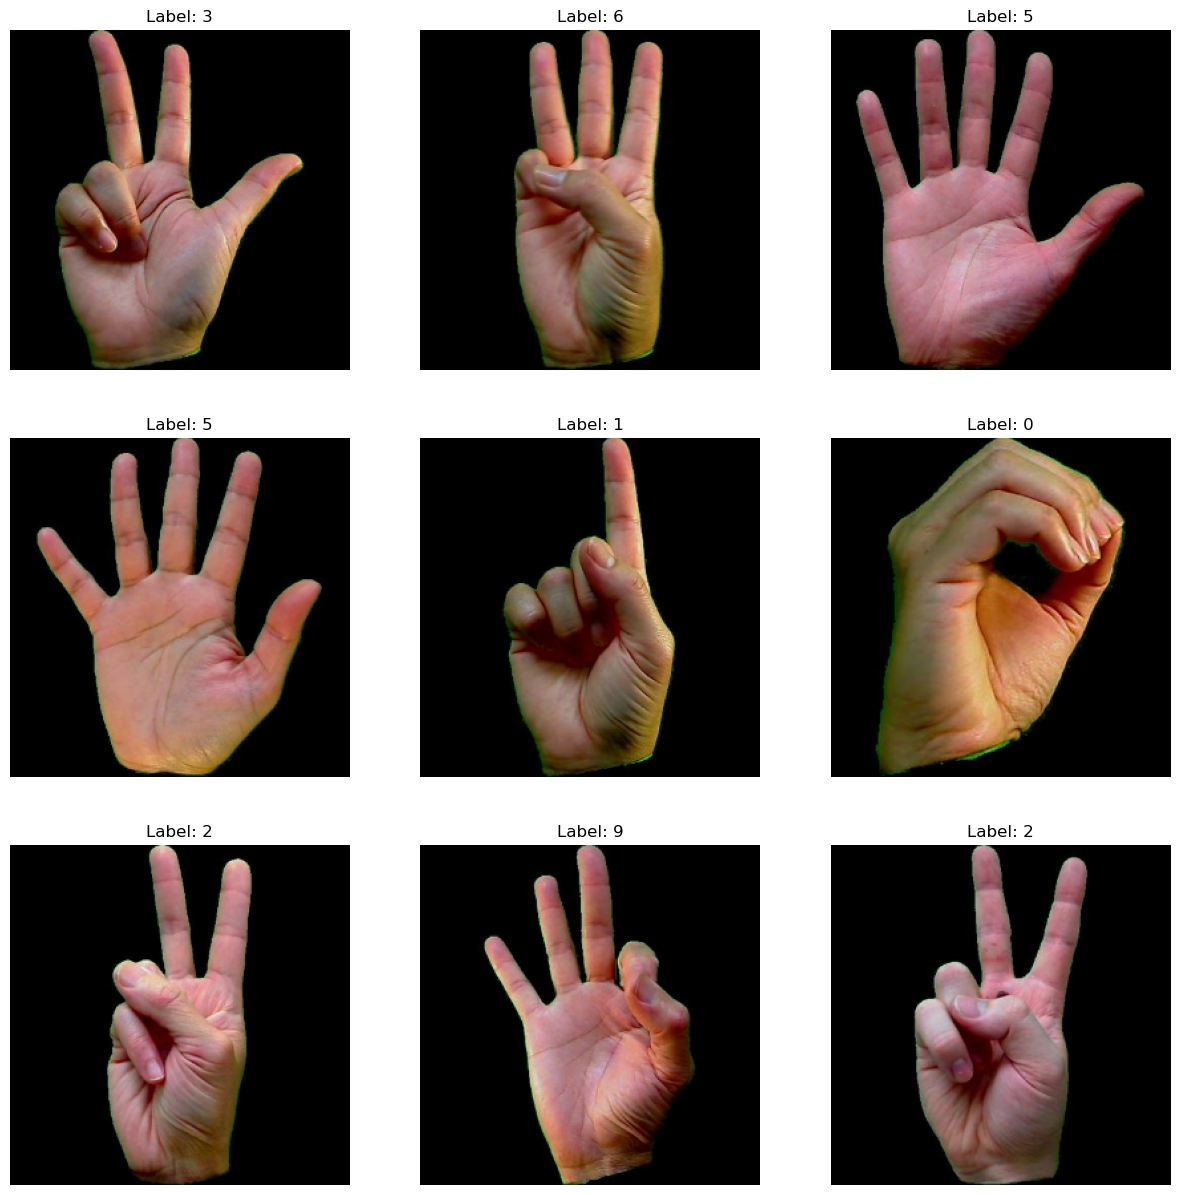

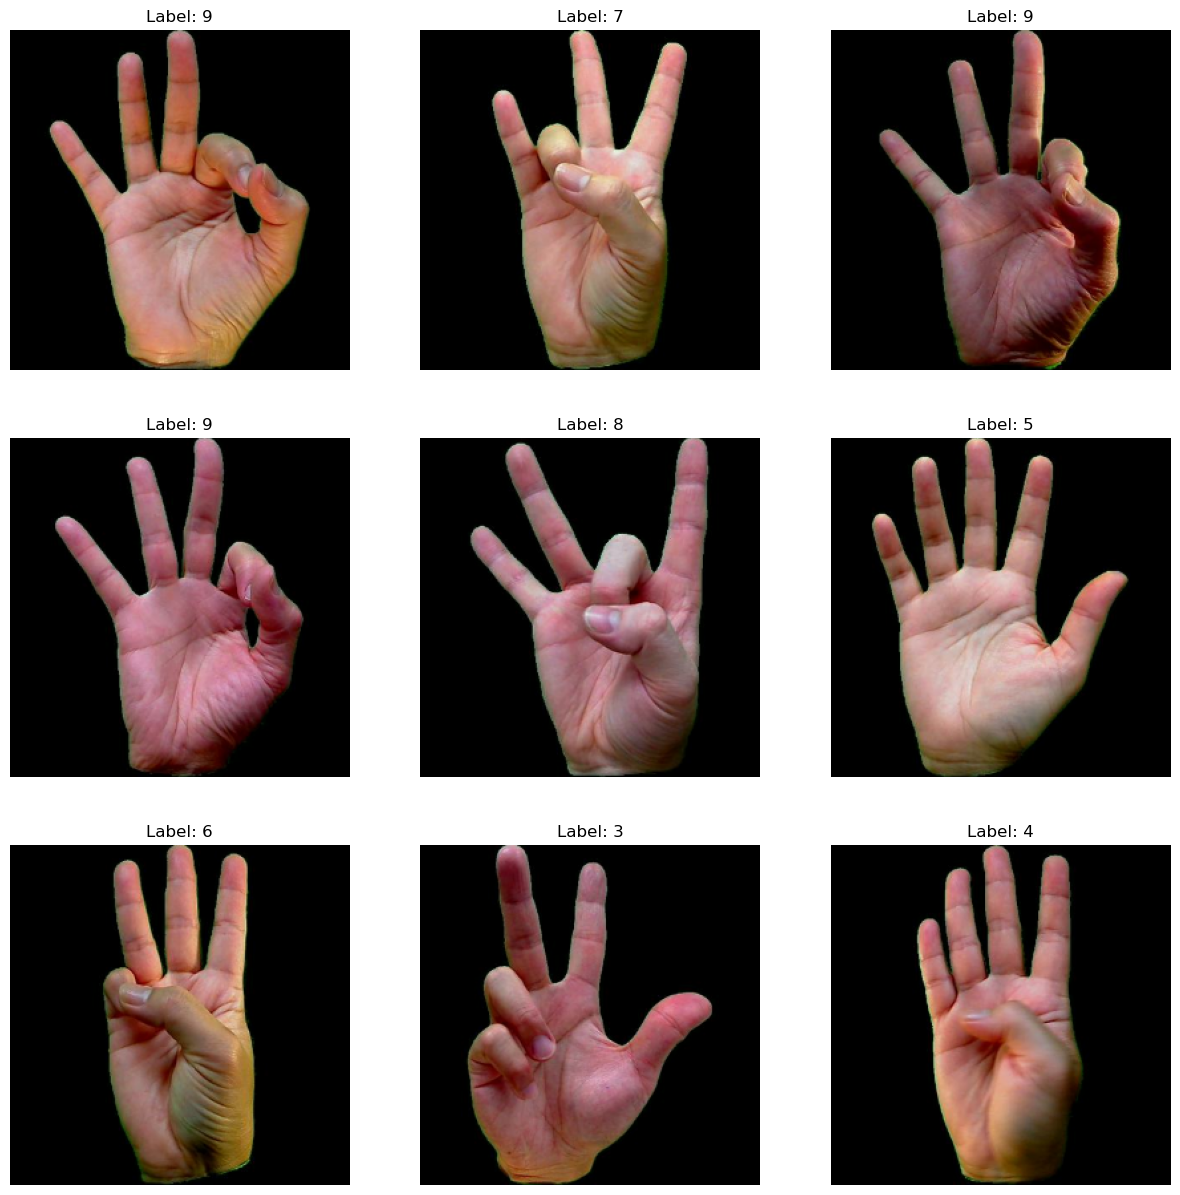

In [8]:
class ImageShowerWithLabels:
    def show_img(self, data):
        plt.figure(figsize=(15, 15))
        for images, labels in data.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                ax.imshow(images[i].numpy().astype("uint8"))
                ax.set_title(f"Label: {labels[i].numpy()}")
                ax.axis("off")

class DatasetPlotterWithLabels:
    def __init__(self, data):
        self.data = data

    def plot_images(self):
        plt.figure(figsize=(15, 15))
        for images, labels in self.data.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                ax.imshow(images[i].numpy().astype("uint8"))
                ax.set_title(f"Label: {labels[i].numpy()}")
                ax.axis("off")

# Usage

# Create an instance of ImageShowerWithLabels
image_shower = ImageShowerWithLabels()
image_shower.show_img(data)

# Create an instance of DatasetPlotterWithLabels and pass the data
dataset_plotter = DatasetPlotterWithLabels(data)
dataset_plotter.plot_images()

#  Loading pre-trained VGG model 

In [9]:
base_vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,))

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 228, 228, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 228, 228, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)       0     

### Freezing the Base VGG Layers

In [11]:
for layer in base_vgg_model.layers:
    layer.trainable = False

# Adding Layers for Transfer Learning

In [12]:
x = Flatten()(base_vgg_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)  # Replace 'num_classes' with the number of classes in your dataset

### Creating Transfer Learning Model

In [13]:
model = Model(inputs=base_vgg_model.input, outputs=output)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 228, 228, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 228, 228, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)       0     

### Compile the model

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Define callbacks

In [16]:
# checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')

# early_stopping_callback = EarlyStopping(patience=3, monitor='val_accuracy', mode='max')

# reduce_lr_callback = ReduceLROnPlateau(factor=0.2, patience=2, monitor='val_loss', mode='min')

#callbacks = [checkpoint_callback, early_stopping_callback]

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model.h5",
        save_best_only=True,
        monitor="val_loss")]

### Training the model using train_data and validate it using val_data

In [18]:
history = model.fit_generator(train_data, epochs=50, validation_data=val_data, callbacks=callbacks)

/tmp/ipykernel_29/832669271.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data, epochs=50, validation_data=val_data, callbacks=callbacks)


Epoch 1/50
15/15 [==============================] - 21s 785ms/step - loss: 0.9000 - accuracy: 0.1739 - val_loss: 0.3820 - val_accuracy: 0.3364
Epoch 2/50
15/15 [==============================] - 8s 519ms/step - loss: 0.4273 - accuracy: 0.3609 - val_loss: 0.2080 - val_accuracy: 0.5727
Epoch 3/50
15/15 [==============================] - 8s 557ms/step - loss: 0.2960 - accuracy: 0.4065 - val_loss: 0.1929 - val_accuracy: 0.6455
Epoch 4/50
15/15 [==============================] - 8s 539ms/step - loss: 0.2457 - accuracy: 0.4891 - val_loss: 0.1734 - val_accuracy: 0.7273
Epoch 5/50
15/15 [==============================] - 9s 582ms/step - loss: 0.2237 - accuracy: 0.5761 - val_loss: 0.1590 - val_accuracy: 0.7364
Epoch 6/50
15/15 [==============================] - 8s 524ms/step - loss: 0.2072 - accuracy: 0.5978 - val_loss: 0.1554 - val_accuracy: 0.7727
Epoch 7/50
15/15 [==============================] - 8s 555ms/step - loss: 0.1966 - accuracy: 0.5978 - val_loss: 0.1313 - val_accuracy: 0.8182
Epoch

### Evaluate the model on the test data

In [19]:
#test_model = keras.models.load_model("./models/convnet_with_just_vgg.keras")
test_model = keras.models.load_model("best_model.h5")

test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test accuracy: {test_accuracy:.3f}")

5/5 [==============================] - 2s 492ms/step - loss: 134.7162 - accuracy: 0.9615
Test accuracy: 0.962


### Saving the model

In [20]:
model_name = 'vgg_digits_best_model.h5'
model.save(model_name, save_format='h5')

# Plotting Model Training and Validation Results

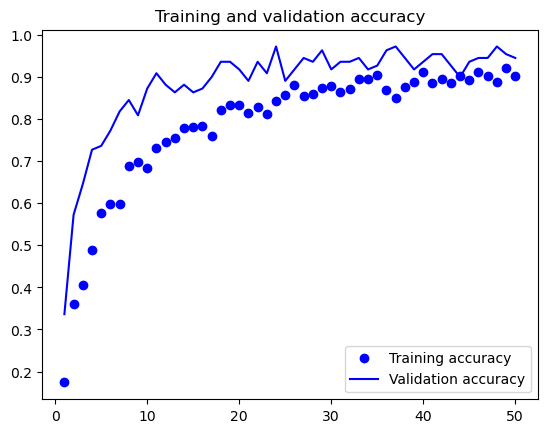

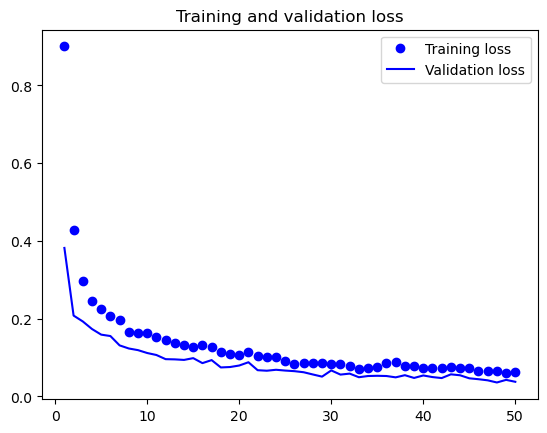

In [21]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Prediction on Test Data

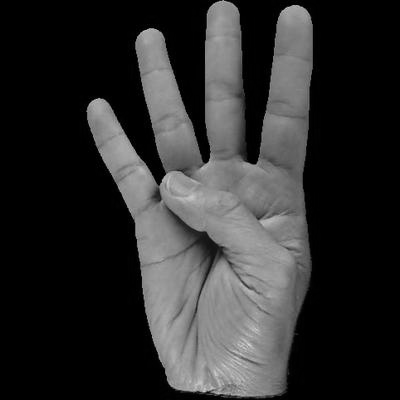

In [23]:
load_img('/kaggle/input/asl-digits-0-9/ASL Digits/test/4/hand1_4_bot_seg_4_cropped.jpeg',model)

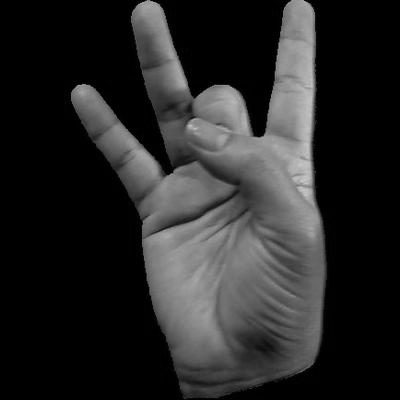

In [26]:
load_img('/kaggle/input/asl-digits-0-9/ASL Digits/test/8/hand2_8_right_seg_2_cropped.jpeg',model)

### Confusion Matrix

In [ ]:
test_labels = test_set.classes
test_predictions = test_model.predict(test_set)
predicted_labels = np.argmax(test_predictions, axis=1)

5/5 [==============================] - 2s 395ms/step


In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_labels, predicted_labels)

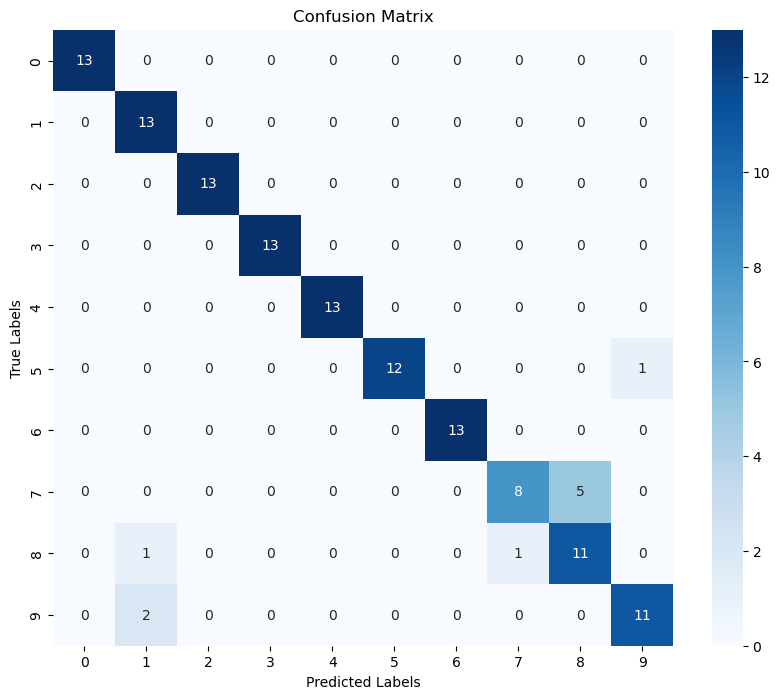

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] # Replace with the names of your classes

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
